# Ejercicio 5

## Preprocesamiento de datos

Descomprimimos cada uno de nuestros archivos *.zip* y los almacenamos en una carpeta llamada *dataset*

In [82]:
from zipfile import ZipFile

# Le hacemos un unzip a nuestro conjunto de entrenamiento.
with ZipFile('dataset/train_dogscats.zip', 'r') as zipObj:
    zipObj.extractall('dataset')

# Le hacemos un unzip a nuestro conjunto de prueba.
with ZipFile('dataset/test_dogscats.zip', 'r') as zipObj:
    zipObj.extractall('dataset')

Creamos un *dataframe* con cada una de las imágenes que están contenidas en la carpeta *train*. Como el nombre de cada imagen nos indica si el animalito es un perro o es un gato, extraeremos esa información.

In [83]:
import os
import pandas as pd

nombres = os.listdir("dataset/train")
categorias = []
for nombre in nombres:
    animal = nombre.split('.')[0] # Obtenemos el nombre del animalito.
    if(animal == 'dog'):
        categorias.append(1)
    else:
        categorias.append(0)
        
data_frame = pd.DataFrame({'nombre'   : nombres,
                           'categoria': categorias
                          })

# Visualizamos el dataframe con 10 archivos.
data_frame.head(10)

,nombre,categoria
0,cat.3145.jpg,0
1,cat.7.jpg,0
2,dog.3377.jpg,1
3,dog.399.jpg,1
4,cat.2181.jpg,0
5,cat.5778.jpg,0
6,cat.7417.jpg,0
7,dog.11297.jpg,1
8,dog.11391.jpg,1
9,cat.4047.jpg,0


Así, obtenemos un *dataframe* con cada una de las imágenes y sus respectivas etiquetas.

Ahora, dividimos nuestro conjunto de datos en entrenamiento y prueba.

In [84]:
from sklearn.model_selection import train_test_split

# Convertimos la variable "categoria" en gato o perro.
data_frame["categoria"] = data_frame["categoria"].replace({0:'gato', 1:'perro'})

# Dividimos nuestro conjunto de datos con un split del 75-25 para entrenamiento y prueba.
X_train, X_test = train_test_split(data_frame, test_size = 0.25, random_state = 42)

# Reestablecemos los índices de nuestros datos.
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

# Obtenemos su respectivo número de columnas. 
total_train = X_train.shape[0]
total_test = X_test.shape[0]

In [85]:
from keras.preprocessing.image import ImageDataGenerator, load_img

# Modificamos las imágenes para poder obtener más datos con los qué entrenar.
datos_train = ImageDataGenerator(rotation_range     = 15,
                                 rescale            = 1./255, # Normalizamos la imagen.
                                 shear_range        = 0.1,
                                 zoom_range         = 0.2,
                                 horizontal_flip    = True,
                                 width_shift_range  = 0.1,
                                 height_shift_range = 0.1
                                )

# Generamos las imágenes de entrenamiento.
generador_train = datos_train.flow_from_dataframe(X_train,
                                                  "dataset/train/",
                                                  x_col       = 'nombre',
                                                  y_col       = 'categoria',
                                                  target_size = (128, 128),
                                                  class_mode  = 'categorical',
                                                  batch_size  = 15
                                                 )

# Generamos las imágenes de prueba.
datos_test = ImageDataGenerator(rescale = 1./255)
generador_test = datos_test.flow_from_dataframe(X_test, 
                                                "dataset/train/", 
                                                x_col       = 'nombre',
                                                y_col       = 'categoria',
                                                target_size = (128, 128),
                                                class_mode  ='categorical',
                                                batch_size  = 15
                                               )

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


## Modelo

In [86]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# Primer capa.
model.add(Convolution2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Segunda capa.
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Tercer capa.
model.add(Convolution2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Cuarta Capa: fully-connected. 
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Clasificador Softmax.
model.add(Dense(2, activation = 'softmax'))

Analizamos el modelo.

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)       

Finalmente, lo compilamos.

In [88]:
model.compile(loss      = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics   = ['accuracy'])

## Entrenamiento y validación.

Notemos que *EarlyStopping* lo utilizamos para evitar el exceso de ajuste (detenemos el aprendizaje después de que 
$epochs = 10$ y el valor de val\_loss no haya disminuido) y *ReduceLROPlateau* lo utilizamos para manejar la tasa de aprendizaje de la red (la reducimos cuando la precisión no aumenta en $2$ steps). 

In [89]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

H = model.fit(generador_train, 
              epochs           = 10,
              validation_data  = generador_test,
              validation_steps = total_test // 15,
              steps_per_epoch  = total_train // 15,
              callbacks        = [EarlyStopping(patience = 10), 
                                  ReduceLROnPlateau(monitor  = 'val_accuracy',
                                                    patience = 2,
                                                    verbose  = 1,
                                                    factor   = 0.5,
                                                    min_lr   = 0.00001)
                                 ]
             )

Epoch 1/10
1250/1250 [==============================] - 1539s 1s/step - loss: 0.7743 - accuracy: 0.6187 - val_loss: 0.5320 - val_accuracy: 0.6755
Epoch 2/10
1250/1250 [==============================] - 1556s 1s/step - loss: 0.5628 - accuracy: 0.7194 - val_loss: 0.4087 - val_accuracy: 0.7440
Epoch 3/10
1250/1250 [==============================] - 1510s 1s/step - loss: 0.5171 - accuracy: 0.7497 - val_loss: 0.4526 - val_accuracy: 0.7904
Epoch 4/10
1250/1250 [==============================] - 1577s 1s/step - loss: 0.4806 - accuracy: 0.7769 - val_loss: 0.4198 - val_accuracy: 0.7801
Epoch 5/10
1250/1250 [==============================] - 1323s 1s/step - loss: 0.4558 - accuracy: 0.7891 - val_loss: 0.1946 - val_accuracy: 0.8141
Epoch 6/10
1250/1250 [==============================] - 1321s 1s/step - loss: 0.4283 - accuracy: 0.8096 - val_loss: 0.3005 - val_accuracy: 0.8279
Epoch 7/10
1250/1250 [==============================] - 1306s 1s/step - loss: 0.4086 - accuracy: 0.8175 - val_loss: 0.8404 -

Evaluamos qué tan bien le fue con nuestro conjunto de prueba.

In [90]:
score = model.evaluate(generador_train, steps = len(generador_train))

1250/1250 [==============================] - 330s 264ms/step


In [92]:
print("Score {}".format(score))

Score [0.23800379037857056, 0.8423466682434082]


Obtenemos un $0.84\%$ de precisión. 

## Gráficas

Visualizamos la gráfica de pérdida de entrenamiento y validación.

Text(0.5, 1.0, 'Pérdida de entrenamiento y validacion')

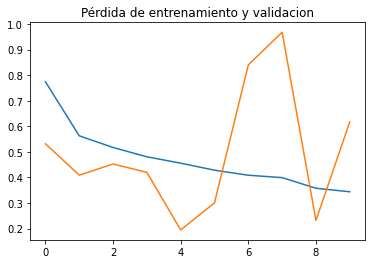

In [93]:
import matplotlib.pyplot as plt

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Pérdida de entrenamiento y validacion')

Visualizamos la gráfica de precisión de entrenamiento y validación.

Text(0.5, 1.0, 'Precisión de entrenamiento y validacion')

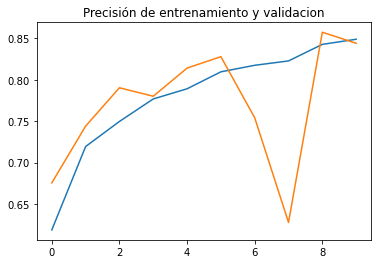

In [95]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Precisión de entrenamiento y validacion')

## Guardamos el modelo

In [96]:
model.save('mi_modelo.h5')

## Testeo

### Preprocesamiento de datos

In [97]:
# Cargamos los nombres de los archivos contenidos en la carpeta test1.
nombres_test = os.listdir("dataset/test1")
dataframe_test = pd.DataFrame({'nombre': nombres_test})

# Obtenemos el número de columnas.
nb_samples = test_df.shape[0]

In [98]:
# Generamos las imágenes para el testeo.
datos_test1 = ImageDataGenerator(rescale = 1./255)
generador_test1 = datos_test1.flow_from_dataframe(dataframe_test, 
                                                  "dataset/test1/", 
                                                  x_col       = 'nombre',
                                                  y_col       = None,
                                                  class_mode  = None,
                                                  target_size = (128, 128),
                                                  batch_size  = 15,
                                                  shuffle     = False
                                                 )

Found 12500 validated image filenames.


In [99]:
predict = model.predict(generador_test1, steps = np.ceil(nb_samples/15))

Para la clasificación categórica, la predicción vendrá con probabilidad de cada categoría. Así que vamos a elegir la categoría que tienen la mayor probabilidad con numpy promedio máx

In [100]:
dataframe_test['categoria'] = np.argmax(predict, axis = -1)

Convertimos la categoría de predicción en nuestras clases generadoras (es decir, en perros y gatos) mediante el uso de train_generator.class_indices.

In [101]:
label_map = dict((v,k) for k,v in generador_train.class_indices.items())
dataframe_test['categoria'] = dataframe_test['categoria'].replace(label_map)

Visualizamos los resultados de las primeras 56 predicciones.

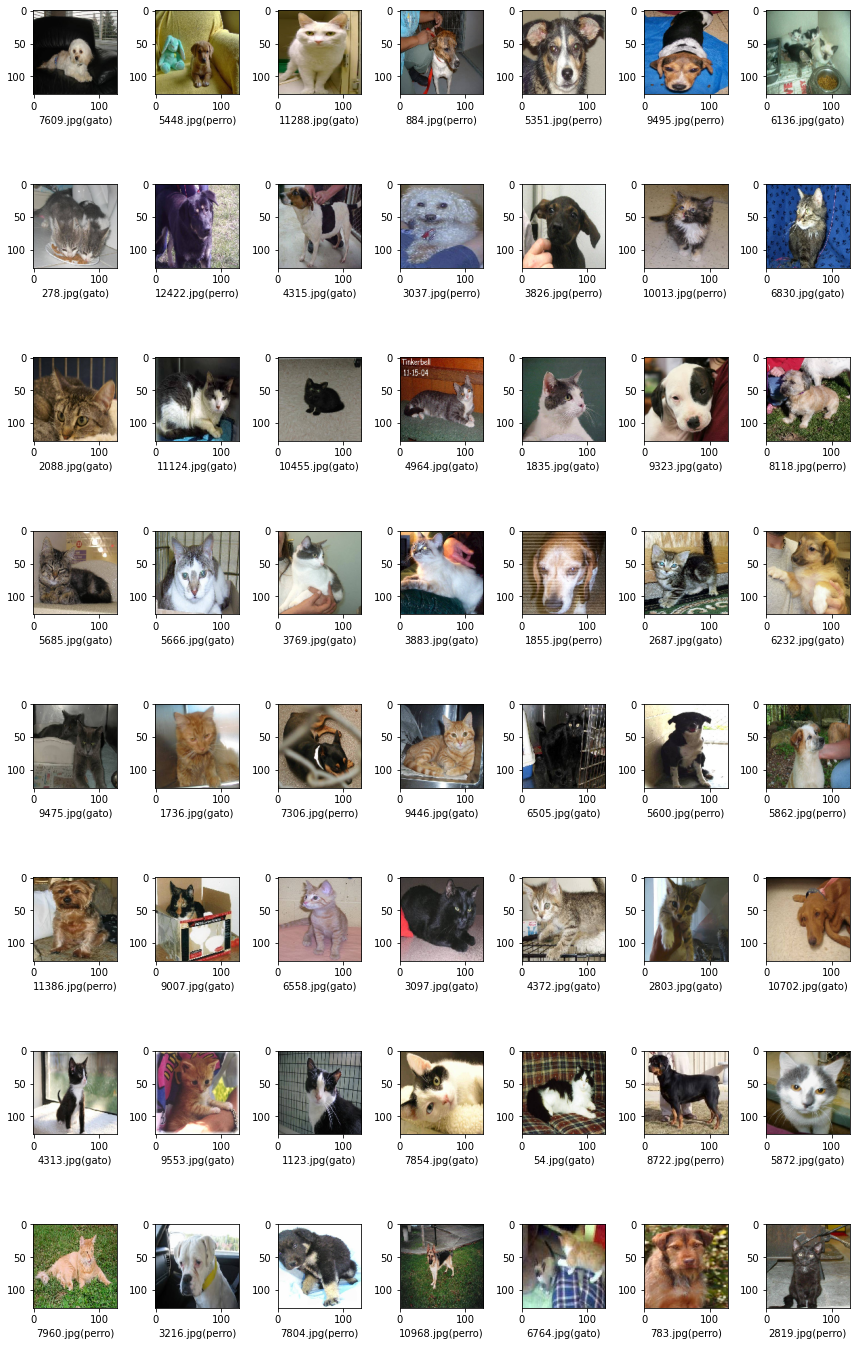

In [102]:
vis = test_df.head(56)
vis.head()
plt.figure(figsize = (12, 24))
for index, row in vis.iterrows():
    nombre = row['filename']
    categoria = row['category']
    imagen = load_img("dataset/test1/" + nombre, target_size = (128, 128))
    plt.subplot(10, 7, index + 1)
    plt.imshow(imagen)
    plt.xlabel(nombre + '(' + "{}".format(categoria) + ')' )
plt.tight_layout()
plt.show()

## Reconocimiento de imágenes

Realizamos el reconocimiento de cada una de las cuatro imágenes solicitadas en la tarea.

In [103]:
from PIL import Image

# Definimos los dos resultados posibles.
categoria_final = {0:'gatito', 1:'perrito'}

# Cargamos la imagen y la modificamos para poder hacer el reconocimiento.
imagen1 = Image.open("imagenes/cat1.jpeg")
imagen1 = imagen1.resize((128, 128))
imagen1 = np.expand_dims(imagen1, axis = 0)
imagen1 = np.array(imagen1)
imagen1 = imagen1 / 255

# Realizamos la predicción.
reconocimiento = model.predict_classes([imagen1])[0]

# Visualizamos el resultado de la predicción.
print(reconocimiento, categoria_final[reconocimiento])

0 gatito


In [104]:
# Cargamos la imagen y la modificamos para poder hacer el reconocimiento.
imagen2 = Image.open("imagenes/cat2.jpg")
imagen2 = imagen2.resize((128, 128))
imagen2 = np.expand_dims(imagen2, axis = 0)
imagen2 = np.array(imagen2)
imagen2 = imagen2 / 255

# Realizamos la predicción.
reconocimiento = model.predict_classes([imagen2])[0]

# Visualizamos el resultado de la predicción.
print(reconocimiento, categoria_final[reconocimiento])

0 gatito


In [105]:
# Cargamos la imagen y la modificamos para poder hacer el reconocimiento.
imagen3 = Image.open("imagenes/dog1.jpeg")
imagen3 = imagen3.resize((128, 128))
imagen3 = np.expand_dims(imagen3, axis = 0)
imagen3 = np.array(imagen3)
imagen3 = imagen3 / 255

# Realizamos la predicción.
reconocimiento = model.predict_classes([imagen3])[0]

# Visualizamos el resultado de la predicción.
print(reconocimiento, categoria_final[reconocimiento])

1 perrito


In [106]:
# Cargamos la imagen y la modificamos para poder hacer el reconocimiento.
imagen4 = Image.open("imagenes/dog2.jpeg") 
imagen4 = imagen4.resize((128, 128))
imagen4 = np.expand_dims(imagen4, axis = 0)
imagen4 = np.array(imagen4)
imagen4 = imagen4 / 255

# Realizamos la predicción.
reconocimiento = model.predict_classes([imagen4])[0]

# Visualizamos el resultado de la predicción.
print(reconocimiento, categoria_final[reconocimiento])

0 gatito
